In [1]:
BATCH_SIZE = 512
IMAGE_SIZE = [100, 100, 3]
NUM_CLASSES = 7

colorNames = ["black", "gold", "green", "pink", "silver", "wood", "yellow"]

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2

## Avoid to use all GPU(s)VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

# Converting the values into features
def _int64_feature(value):  # _int64 is used for numeric values
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _bytes_feature(value):  # _bytes is used for string/char values
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
tile_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'color': tf.io.FixedLenFeature([], tf.int64)
}
def _parse_image_function(example_proto):
    data = tf.io.parse_single_example(example_proto, tile_feature_description) # Parse the input tf.train.Example proto using dictionary.
    # label = data['label']
    label = tf.one_hot(indices=data['color'], depth=NUM_CLASSES, on_value=1.0, off_value=0.0)
    image = tf.io.decode_png(data['image'])  # Auto detect image shape when decoded
    output = {}
    # return [image], [label]
    return image, label

In [3]:
dataset_config = json.load(open(os.path.join('../../config/dataset_config.json')))
output_path = dataset_config['capture_path']
color_tfrecord_pattern = os.path.join(output_path, 'color.tfrecords-????-of-????')

In [4]:
shards = tf.data.TFRecordDataset.list_files(color_tfrecord_pattern)
shards = shards.shuffle(buffer_size=1000) # Make sure to fully shuffle the list of tfrecord files.
# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = shards.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
dataset = dataset.map(_parse_image_function, num_parallel_calls=4)
split_filter = [0, 0, 0, 0, 0, 0, 0, 1, 1, 2]   # Use to filter dataset as train:val:test = 70:20:10
train_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 <= 6) \
                    .map(lambda x,y: y)
val_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 == 7 or x % 10 == 8) \
                    .map(lambda x,y: y)
test_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 == 9) \
                    .map(lambda x,y: y)
train_set = train_set.shuffle(2000)
train_set = train_set.batch(BATCH_SIZE, drop_remainder=True)
val_set = val_set.shuffle(2000)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True)
test_set = test_set.shuffle(2000)
test_set = test_set.batch(BATCH_SIZE, drop_remainder=True)

In [5]:
from tensorflow.python.keras.models import Sequential

img_augmentation = Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ],
    name="img_augmentation",
)

# base_model = tf.keras.applications.EfficientNetB0(input_shape=IMAGE_SIZE,
#                                                   include_top=False,
#                                                   weights='imagenet')
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES) # 7 classes prediction
])

In [6]:
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE)
x = img_augmentation(inputs)
outputs = base_model(x, training=True)
model = tf.keras.Model(inputs, outputs)

# for layer in base_model.layers[:unlock_at]: layer.trainable = False     # Freeze all the layers before the `unlock_at` layer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 100, 100, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 7)                 1204263   
Total params: 1,204,263
Trainable params: 1,204,263
Non-trainable params: 0
_________________________________________________________________


In [8]:
len(model.trainable_variables)

10

In [9]:
# First validation (before training: should be around 14.28% due to balanced 7 classes)
loss0, accuracy0 = model.evaluate(test_set)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 9s 308ms/step - loss: 1.9623 - accuracy: 0.1406
initial loss: 1.96
initial accuracy: 0.14


In [10]:
# Initial Training
history = model.fit(train_set,
                    epochs=20,
                    validation_data=val_set)

Epoch 1/20
144/144 [==============================] - 23s 149ms/step - loss: 1.6525 - accuracy: 0.3760 - val_loss: 1.2012 - val_accuracy: 0.5713
Epoch 2/20
144/144 [==============================] - 21s 145ms/step - loss: 0.9625 - accuracy: 0.6449 - val_loss: 0.6540 - val_accuracy: 0.7631
Epoch 3/20
144/144 [==============================] - 21s 141ms/step - loss: 0.6415 - accuracy: 0.7671 - val_loss: 0.4965 - val_accuracy: 0.8119
Epoch 4/20
144/144 [==============================] - 20s 141ms/step - loss: 0.5136 - accuracy: 0.8116 - val_loss: 0.4061 - val_accuracy: 0.8499
Epoch 5/20
144/144 [==============================] - 20s 141ms/step - loss: 0.4630 - accuracy: 0.8312 - val_loss: 0.3454 - val_accuracy: 0.8749
Epoch 6/20
144/144 [==============================] - 21s 146ms/step - loss: 0.4164 - accuracy: 0.8504 - val_loss: 0.3152 - val_accuracy: 0.8873
Epoch 7/20
144/144 [==============================] - 21s 145ms/step - loss: 0.3857 - accuracy: 0.8619 - val_loss: 0.2941 - val_ac

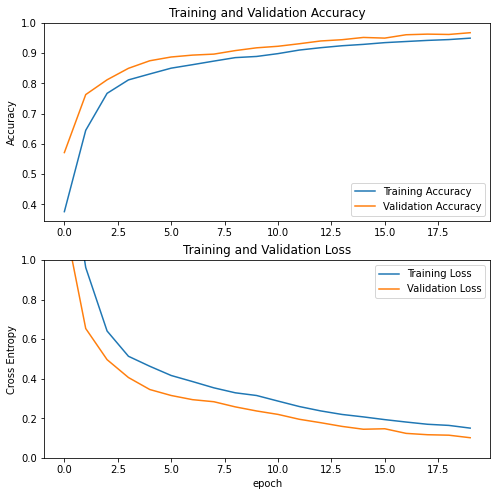

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
len(model.trainable_variables)

10

In [13]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)

20/20 [==============================] - 8s 315ms/step - loss: 0.1053 - accuracy: 0.9655
Test accuracy : 0.965527355670929


In [14]:
# Save Tensorflow model (*.pb)
model_config = json.load(open(os.path.join('../../config/model_config.json')))
saved_model_path = os.path.join(model_config['base_path'], model_config['binary_classifier'])
model.save(saved_model_path)

INFO:tensorflow:Assets written to: /media/teera/buffer/model/classification/chess/binary/assets


## Convert the TensorFlow model with OpenVINO Model Optimizer

In [15]:
# The paths of the source and converted models
model_name = "binary"
ir_data_type = "FP16"
ir_model_name = "binary_ir"

# Get the path to the Model Optimizer script

# Construct the command for Model Optimizer
mo_command = f"""mo
                 --saved_model_dir "{saved_model_path}"
                 --input_shape "[-1,100,100,3]"
                 --data_type "{ir_data_type}"
                 --output_dir "{saved_model_path}"
                 --model_name "{ir_model_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
print(mo_command)

Model Optimizer command to convert TensorFlow to OpenVINO:
mo --saved_model_dir "/media/teera/buffer/model/classification/chess/binary" --input_shape "[-1,100,100,3]" --data_type "FP16" --output_dir "/media/teera/buffer/model/classification/chess/binary" --model_name "binary_ir"


In [16]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/media/teera/buffer/model/classification/chess/binary
	- IR output name: 	binary_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[-1,100,100,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	Fa

## Test

In [17]:
from openvino.runtime import Core

model_config = json.load(open(os.path.join('../../config/model_config.json')))
saved_model_path = os.path.join(model_config['base_path'], model_config['binary_classifier'])
model.save(saved_model_path)
model_xml = os.path.join(saved_model_path, f"{ir_model_name}.xml")
model_weight = os.path.join(saved_model_path, f"{ir_model_name}.bin")

# Load model
ie = Core()
model = ie.read_model(model=model_xml, weights=model_weight)
model.reshape([64, 100, 100, 3]) # set input as fixed batch

compiled_model = ie.compile_model(model=model, device_name="CPU")
compiled_model_binary = ie.compile_model(model, "GPU", {"PERFORMANCE_HINT": "THROUGHPUT"})
infer_request_binary = compiled_model_binary.create_infer_request()

# infer_request_binary.infer([CNNinputs_padded])
# board_result_binary = infer_request_binary.get_output_tensor().data[:].reshape(8, 8)

# del model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
print(input_layer, output_layer)

INFO:tensorflow:Assets written to: /media/teera/buffer/model/classification/chess/binary/assets


RuntimeError: Failed to create plugin /home/teera/openvino_env/lib/python3.8/site-packages/openvino/libs/libopenvino_intel_gpu_plugin.so for device GPU
Please, check your environment
[CLDNN ERROR]. No GPU device was found.


In [ ]:
# Run inference on the test image...
test_image = cv2.imread("../test_CNNinputs.png")
plt.imshow(cv2.cvtColor(test_image, code=cv2.COLOR_BGR2RGB))
CNNinputs_resized = []
for i in range(8):
    for j in range(8):
        tile_img = test_image[100*i:100*(i+1),100*j:100*(j+1)]
        # Resize the image to the network input shape.
        resized_image = cv2.resize(src=tile_img, dsize=IMAGE_SIZE[:2])
        # Transpose the image to the network input shape.
        input_image = np.expand_dims(resized_image, 0)
        CNNinputs_resized.append(input_image.reshape(IMAGE_SIZE))

print(len(CNNinputs_resized))
print(CNNinputs_resized[0].shape)
infer_request_binary.infer([CNNinputs_resized])
board_result_binary = infer_request_binary.get_output_tensor().data[:].reshape(8, 8)
board_result_binary = np.where(board_result_binary < 0, 0, 1)   # Interpreted prediction
print(board_result_binary)